## Peramalan Produksi Batu Bara PT KTC Coal Mining & Energy Menggunakan Metode _Autoregressive Integrated Moving Average_ (ARIMA)

### Import Library yang Dibutuhkan

In [29]:
# Import library
import warnings
warnings.filterwarnings("ignore")

# Library untuk manipulasi data dan analisis deret waktu
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Library untuk pemilihan model dan evaluasi
from scipy.stats import boxcox, boxcox_normmax, boxcox_llf, kstest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### Load Dataset dan Preprocessing Data

In [30]:
# Load dataset utama
df = pd.read_csv('data-mentah-latest.csv')
df.head()

,Month,Actual
0,Jan-20,39.168 MT
1,Feb-20,30.939 MT
2,Mar-20,30.821 MT
3,Apr-20,39.857 MT
4,May-20,54.533 MT


In [31]:
# Cleaning data dan preprocessing dataset utama, tanggal tidak dipreprocess karena model hanya mengambil nilai pada kolom aktual
month = pd.to_datetime(df['Month'], format='%b-%y', errors='coerce')
df['Month'] = month.dt.to_period('M').dt.to_timestamp()

actual = (
    df['Actual'].astype(str)
        .str.replace(' MT', '', regex=False)
        .str.replace(r'[^0-9]', '', regex=True)
)

df = (
    df[df['Month'] >= pd.Timestamp('2020-01-01')]
    .loc[:, ['Month', 'Actual']]
    .sort_values('Month')
    .reset_index(drop=True)
)
df['Actual'] = pd.to_numeric(actual, errors='coerce').astype('Int64')

In [32]:
# Melihat informasi dataset utama setelah preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   60 non-null     datetime64[ns]
 1   Actual  60 non-null     Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 1.1 KB


In [33]:
df['Actual'].describe()

count            60.0
mean     51426.183333
std      28228.561711
min            6014.0
25%           30438.0
50%           45686.0
75%           70518.0
max          117693.0
Name: Actual, dtype: Float64

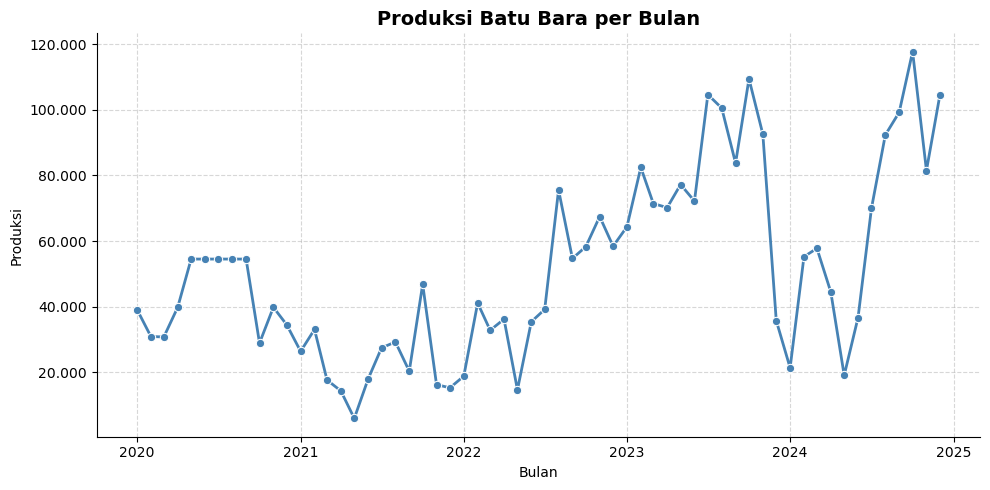

In [34]:
# Visualisasi data produksi batu bara per bulan
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Month', y='Actual', marker='o', linewidth=2, color='steelblue')

plt.title('Produksi Batu Bara per Bulan', fontsize=14, weight='bold')
plt.xlabel('Bulan')
plt.ylabel('Produksi')

plt.ticklabel_format(style='plain', axis='y', useOffset=False)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", "."))
)

sns.despine()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Plot Box-Cox untuk Melihat Stasioneritas Variansi pada Data

In [35]:
def compute_ci_95(y, lambdas, llf_vals, lam_hat):
    LL_hat = boxcox_llf(lam_hat, y)
    threshold = LL_hat - 1.92073

    valid = np.where(llf_vals >= threshold)[0]

    if len(valid) == 0:
        return None, None

    ci_low = lambdas[valid[0]]
    ci_high = lambdas[valid[-1]]

    return ci_low, ci_high


def plot_boxcox(series, title="Box-Cox Plot"):
    """
    Plot Box-Cox tanpa shifting, karena data sudah dijamin > 0.
    """
    # langsung convert ke numpy array float
    y = pd.Series(series).dropna().astype(float).values

    # grid lambda
    lambdas = np.linspace(-5, 5, 501)
    llf_vals = np.array([boxcox_llf(lmbda, y) for lmbda in lambdas])

    # estimasi lambda
    lam_hat = boxcox_normmax(y, method="mle")

    # hitung CI 95%
    ci_low, ci_high = compute_ci_95(y, lambdas, llf_vals, lam_hat)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(lambdas, llf_vals, label="Log-likelihood curve")

    # λ-hat
    plt.axvline(lam_hat, color="k", linewidth=2,
                label=rf"$\hat\lambda$ = {lam_hat:.4f}")

    # CI 95%
    if ci_low is not None and ci_high is not None:
        plt.axvline(ci_low, color="k", linestyle="--")
        plt.axvline(ci_high, color="k", linestyle="--",
                    label=f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

    plt.title(title)
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return lam_hat, (ci_low, ci_high)

### Plot Box-Cox Sebelum Transformasi

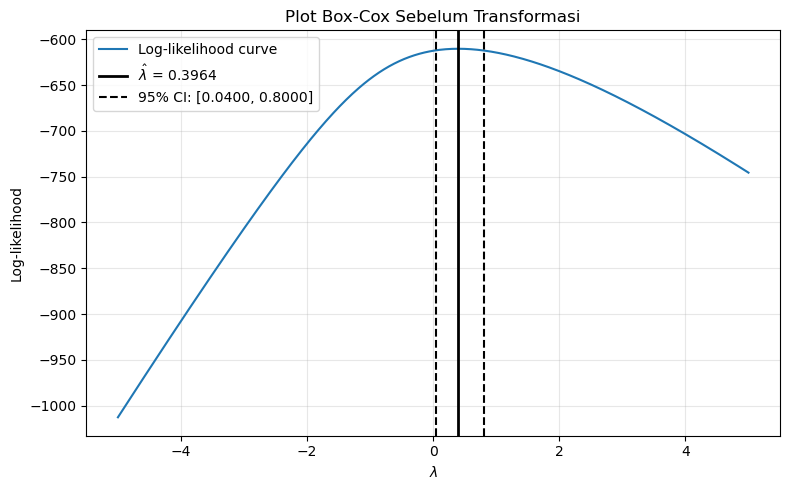

In [36]:
lam_before, ci_before = plot_boxcox(
    df["Actual"],
    title="Plot Box-Cox Sebelum Transformasi"
)

### Plot Box-Cox setelah Transformasi

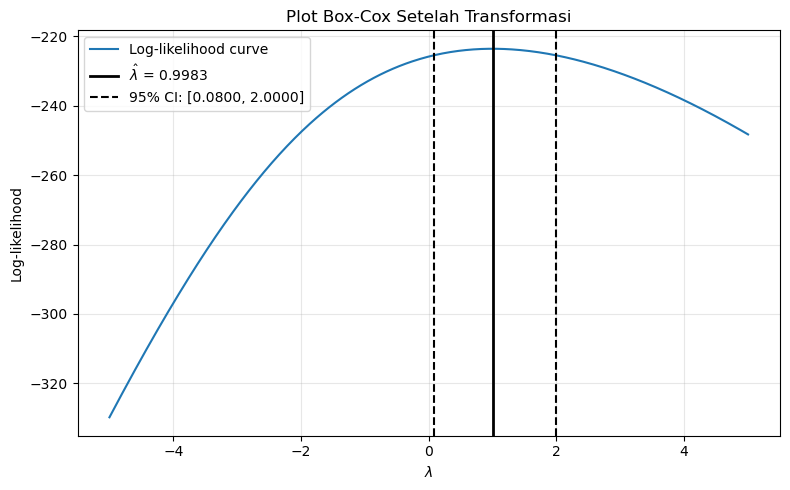

In [37]:
y_bc = boxcox(df["Actual"], lmbda=lam_before)
df['Transformed_Actual'] = y_bc

lam_after, ci_after = plot_boxcox(
    df['Transformed_Actual'],
    title="Plot Box-Cox Setelah Transformasi"
)

### Grafik Data setelah Transformasi Box-Cox

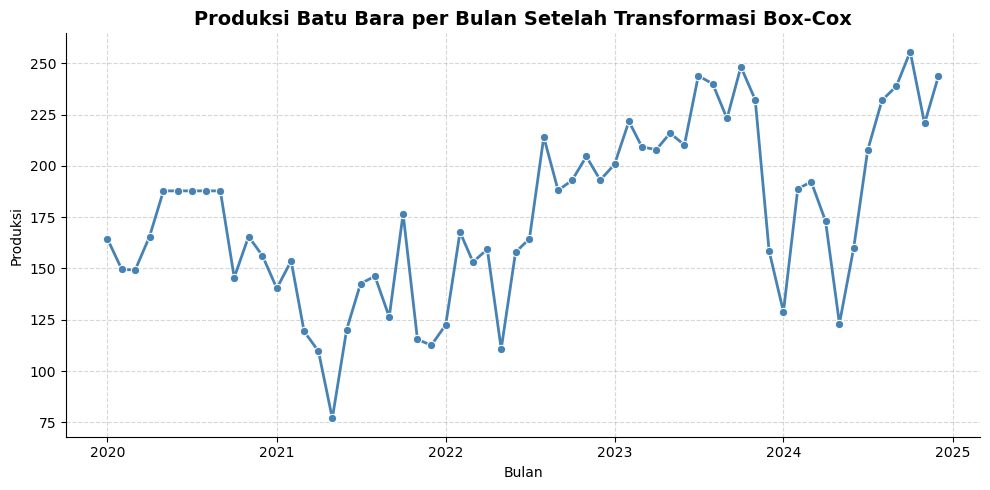

In [38]:
# Visualisasi data produksi batu bara per bulan setelah transformasi Box-Cox
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Month', y='Transformed_Actual', marker='o', linewidth=2, color='steelblue')

plt.title('Produksi Batu Bara per Bulan Setelah Transformasi Box-Cox', fontsize=14, weight='bold')
plt.xlabel('Bulan')
plt.ylabel('Produksi')

plt.ticklabel_format(style='plain', axis='y', useOffset=False)

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", "."))
)

sns.despine()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Uji Augmented Dickey-Fuller (ADF) untuk Stasioneritas Mean

In [39]:
# Uji Augmented Dickey-Fuller (ADF) untuk menguji stasioneritas data
adf_result = adfuller(df['Transformed_Actual'].dropna())
print('--- Uji Augmented Dickey-Fuller (ADF) ---')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

if adf_result[1] < 0.05:
    print("\nData telah stasioner (p-value < 0.05)")
else:
    print("\nData belum stasioner (p-value ≥ 0.05)")

--- Uji Augmented Dickey-Fuller (ADF) ---
ADF Statistic: -2.4990
p-value: 0.1157
Critical Value (1%): -3.5464
Critical Value (5%): -2.9119
Critical Value (10%): -2.5937

Data belum stasioner (p-value ≥ 0.05)


### Plot Data dan Hasil Uji Setelah Differencing

In [40]:
# Melakukan differencing untuk membuat data menjadi stasioner
df['Transformed_Actual_diff'] = df['Transformed_Actual'].diff()

In [41]:
# Uji Augmented Dickey-Fuller (ADF) untuk menguji stasioneritas data
adf_result = adfuller(df['Transformed_Actual_diff'].dropna())
print('--- Uji Augmented Dickey-Fuller (ADF) ---')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.11f}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

if adf_result[1] < 0.05:
    print("\nData telah stasioner (p-value < 0.05)")
else:
    print("\nData belum stasioner (p-value ≥ 0.05)")

--- Uji Augmented Dickey-Fuller (ADF) ---
ADF Statistic: -6.6549
p-value: 0.00000000501
Critical Value (1%): -3.5529
Critical Value (5%): -2.9147
Critical Value (10%): -2.5951

Data telah stasioner (p-value < 0.05)


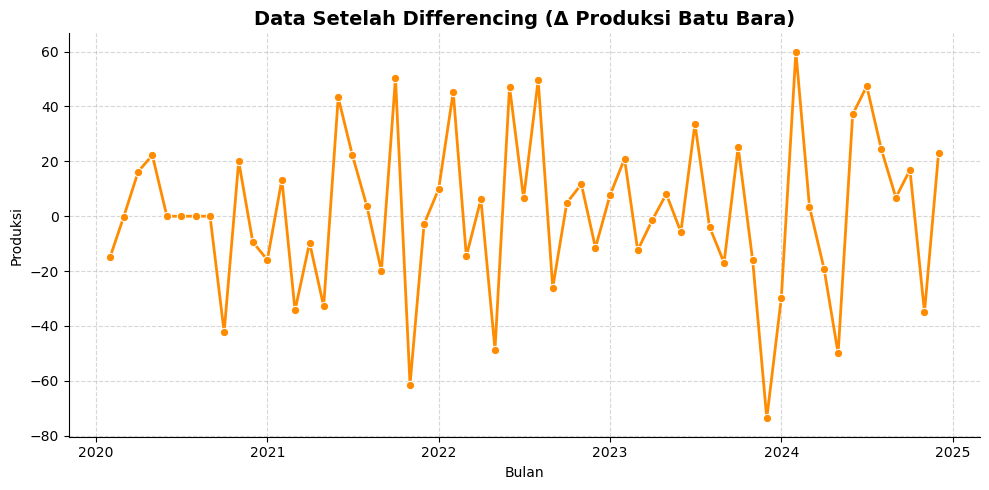

In [42]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Month', y='Transformed_Actual_diff', marker='o', linewidth=2, color='darkorange')
plt.title('Data Setelah Differencing (Δ Produksi Batu Bara)', fontsize=14, weight='bold')
plt.xlabel('Bulan')
plt.ylabel('Produksi')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
sns.despine()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Menyiapkan Data Untuk Identifikasi Model ARIMA

In [43]:
# Menyiapkan data setelah differencing untuk pemodelan
df_copy = df.dropna()
y = df_copy["Transformed_Actual_diff"]

### Plot ACF dan PACF untuk Identifikasi Parameter ARIMA menggunakan Data Setelah Differencing

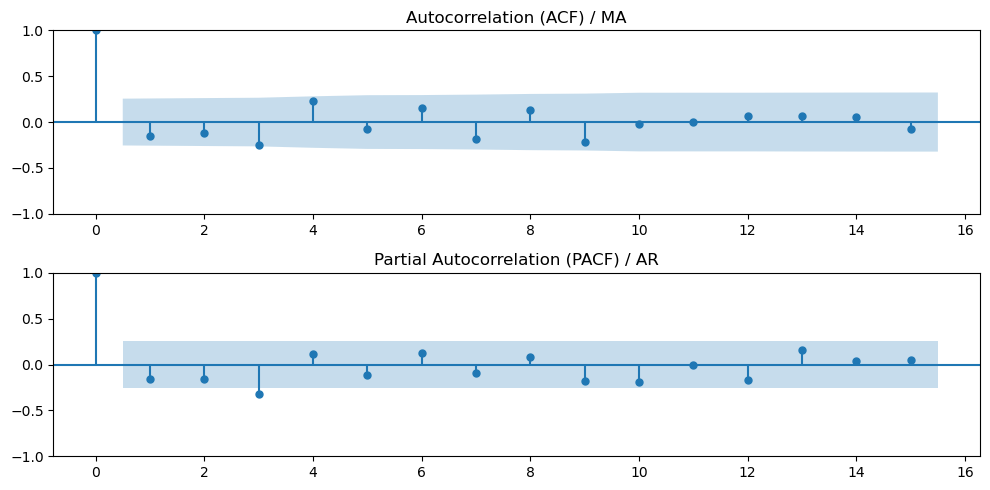

In [44]:
# Plot ACF and PACF untuk menentukan parameter AR dan MA
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# Untuk parameter MA
plot_acf(y, lags=15, ax=ax[0])

# Untuk parameter AR
plot_pacf(y, lags=15, ax=ax[1])
ax[0].set_title('Autocorrelation (ACF) / MA')
ax[1].set_title('Partial Autocorrelation (PACF) / AR')

plt.tight_layout()
plt.show()

p=3, d=1, q=0

- ARIMA(p, d, q)
- ARIMA(3, 1, 0)
- ARIMA(3, 1, 1)
- ARIMA(2, 1, 0)
- ARIMA(2, 1, 1)
- ARIMA(4, 1, 0)
- ARIMA(4, 1, 1)

In [45]:
model_tentatif = [
    (1, 1, 0),
    (0, 1, 1),
    (2, 1, 0),
    (2, 1, 1),
    (3, 1, 0),
    (3, 1, 1),
    (4, 1, 0),
    (4, 1, 1),
]

### Penaksiran Parameter ARIMA

In [46]:
def estimasi_arima(series, order):
    return ARIMA(series, order=order).fit()

def estimasi_banyak_arima(series, model_tentatif):
    result_estimasi = {}
    for order in model_tentatif:
        result_estimasi[order] = ARIMA(series, order=order).fit()
    return result_estimasi

import numpy as np
import pandas as pd

def result_koefisien_arima(result_estimasi, digits=5):
    """
    Menghasilkan result tabel koefisien ARIMA
    max AR dan MA diambil otomatis dari model tentatif
    """

    # ambil max p dan q dari dict estimasi
    orders = list(result_estimasi.keys())
    max_ar = max(p for p, d, q in orders)
    max_ma = max(q for p, d, q in orders)

    rows = []
    for order, model in result_estimasi.items():
        coef = model.params
        row = {"Model": f"ARIMA{order}"}

        # koefisien untuk tampilan (kolom konsisten)
        for i in range(1, max_ar + 1):
            row[f"AR({i})"] = coef.get(f"ar.L{i}", np.nan)

        for j in range(1, max_ma + 1):
            row[f"MA({j})"] = coef.get(f"ma.L{j}", np.nan)

        rows.append(row)

    result_coef = pd.DataFrame(rows)

    # urutan kolom final
    cols = (
        ["Model"]
        + [f"AR({i})" for i in range(1, max_ar + 1)]
        + [f"MA({j})" for j in range(1, max_ma + 1)]
    )
    result_coef = result_coef[cols]

    # pembulatan tampilan
    result_coef_tampil = result_coef.copy()
    for c in result_coef_tampil.columns:
        if c != "Model":
            result_coef_tampil[c] = result_coef_tampil[c].apply(
                lambda x: round(float(x), digits) if pd.notna(x) else np.nan
            )

    print("=== Tabel Koefisien ARIMA ===")
    print(result_coef_tampil.fillna("-").to_string(index=False))

    return result_coef

result_estimasi = estimasi_banyak_arima(y, model_tentatif)
result_coef = result_koefisien_arima(result_estimasi)

=== Tabel Koefisien ARIMA ===
         Model    AR(1)    AR(2)    AR(3)    AR(4)    MA(1)
ARIMA(1, 1, 0) -0.51186        -        -        -        -
ARIMA(0, 1, 1)        -        -        -        -  -0.9978
ARIMA(2, 1, 0) -0.64061  -0.2554        -        -        -
ARIMA(2, 1, 1)   -0.164 -0.13663        -        - -0.99596
ARIMA(3, 1, 0) -0.77675 -0.58869 -0.51565        -        -
ARIMA(3, 1, 1) -0.21503 -0.18919 -0.30009        - -0.99654
ARIMA(4, 1, 0) -0.86695 -0.69179 -0.64749  -0.1678        -
ARIMA(4, 1, 1) -0.16775  -0.1585 -0.26807  0.13985 -0.99715


### Uji Signifikansi Parameter ARIMA untuk Model yang Layak

In [47]:
def result_uji_signifikansi_arima(result_estimasi, alpha=0.05, digits=5):
    # ambil max p dan q dari dict estimasi
    orders = list(result_estimasi.keys())
    max_ar = max(p for p, d, q in orders)
    max_ma = max(q for p, d, q in orders)

    rows = []
    for order, model in result_estimasi.items():
        p, d, q = order
        pvals = model.pvalues

        row = {"Model": f"ARIMA{order}"}

        # p-value untuk tampilan (kolom konsisten)
        for i in range(1, max_ar + 1):
            row[f"AR({i})"] = pvals.get(f"ar.L{i}", np.nan)

        for j in range(1, max_ma + 1):
            row[f"MA({j})"] = pvals.get(f"ma.L{j}", np.nan)

        # p-value untuk uji (hanya parameter yang ada)
        param_pvals = []
        for i in range(1, p + 1):
            v = pvals.get(f"ar.L{i}", np.nan)
            if pd.notna(v):
                param_pvals.append(float(v))

        for j in range(1, q + 1):
            v = pvals.get(f"ma.L{j}", np.nan)
            if pd.notna(v):
                param_pvals.append(float(v))

        row["Kesimpulan"] = (
            "Layak" if param_pvals and all(v < alpha for v in param_pvals)
            else "Tidak Layak"
        )

        rows.append(row)

    result_pval = pd.DataFrame(rows)

    # urutan kolom final
    cols = (
        ["Model"]
        + [f"AR({i})" for i in range(1, max_ar + 1)]
        + [f"MA({j})" for j in range(1, max_ma + 1)]
        + ["Kesimpulan"]
    )
    result_pval = result_pval[cols]

    # pembulatan
    result_pval_tampil = result_pval.copy()
    for c in result_pval_tampil.columns:
        if c not in ["Model", "Kesimpulan"]:
            result_pval_tampil[c] = result_pval_tampil[c].apply(
                lambda x: round(float(x), digits) if pd.notna(x) else np.nan
            )

    print("\n=== Tabel P-Value ARIMA ===")
    print(result_pval_tampil.fillna("-").to_string(index=False))

    return result_pval

result_pval = result_uji_signifikansi_arima(result_estimasi)


=== Tabel P-Value ARIMA ===
         Model    AR(1)    AR(2)    AR(3)    AR(4)    MA(1)  Kesimpulan
ARIMA(1, 1, 0)  0.00001        -        -        -        -       Layak
ARIMA(0, 1, 1)        -        -        -        -  0.61358 Tidak Layak
ARIMA(2, 1, 0)      0.0   0.0604        -        -        - Tidak Layak
ARIMA(2, 1, 1)  0.21582  0.40581        -        -  0.42629 Tidak Layak
ARIMA(3, 1, 0)      0.0  0.00012  0.00002        -        -       Layak
ARIMA(3, 1, 1)  0.07829   0.2022   0.0166        -  0.33777 Tidak Layak
ARIMA(4, 1, 0)      0.0  0.00018  0.00016  0.32403        - Tidak Layak
ARIMA(4, 1, 1)  0.19189  0.33943  0.04588  0.35515  0.52044 Tidak Layak


### Uji Residual Ljung-Box (_white noise_) pada Model ARIMA dari Hasil Uji Signifikansi Parameter

In [48]:
def uji_residual_ljungbox(series, orders, lags=[12, 24, 36, 48], alpha=0.05):
    rows = []

    for order in orders:
        p, d, q = order
        model = ARIMA(series, order=order).fit()
        resid = model.resid.dropna()

        # uji Ljung-Box
        lb = acorr_ljungbox(resid, lags=lags, return_df=True)

        row = {"Model": f"ARIMA{order}"}

        # p-value di tiap lag
        for lag in lags:
            col_name = f"Lag {lag}"
            row[col_name] = float(lb.loc[lag, "lb_pvalue"])

        # kesimpulan: Layak jika semua p-value > alpha (tidak ada autokorelasi signifikan)
        pvals = [row[f"Lag {lag}"] for lag in lags]
        if all(pv > alpha for pv in pvals):
            row["Kesimpulan"] = "Layak"
        else:
            row["Kesimpulan"] = "Tidak Layak"

        rows.append(row)

    df = pd.DataFrame(rows)

    # urutkan kolom sesuai contoh
    ordered_cols = ["Model"] + [f"Lag {lag}" for lag in lags] + ["Kesimpulan"]
    df = df[ordered_cols]

    df_tampil = df.copy()
    for lag in lags:
        col = f"Lag {lag}"
        df_tampil[col] = df_tampil[col].round(3)
    print(df_tampil.to_string(index=False))

    return df

orders_tentatif = [
    (1, 1, 0),
    (3, 1, 0),
]

hasil_residual = uji_residual_ljungbox(
    series=y,
    orders=orders_tentatif,
    lags=[12, 24, 36, 48],
    alpha=0.05
)

         Model  Lag 12  Lag 24  Lag 36  Lag 48  Kesimpulan
ARIMA(1, 1, 0)   0.030   0.093   0.057   0.113 Tidak Layak
ARIMA(3, 1, 0)   0.149   0.174   0.192   0.302       Layak


### Uji Kenormalan dengan Kolmogorov-Smirnov untuk Memastikan Residual Berdistribusi Normal

In [49]:
def uji_kenormalan_ks(series, orders, alpha=0.05):
    rows = []

    for order in orders:
        p, d, q = order
        model = ARIMA(series, order=order).fit()
        resid = model.resid.dropna()

        # standarkan residual: Z ~ N(0,1) jika normal
        z = (resid - resid.mean()) / resid.std(ddof=1)

        # uji K-S terhadap distribusi Normal(0,1)
        ks_stat, pval = kstest(z, 'norm')

        row = {
            "Model": f"ARIMA{order}",
            "Nilai p-value": float(pval)
        }

        # jika p-value > alpha maka Layak
        if pval > alpha:
            row["Kesimpulan"] = "Layak"
        else:
            row["Kesimpulan"] = "Tidak Layak"

        rows.append(row)

    df = pd.DataFrame(rows)

    # versi tampilan
    df_tampil = df.copy()
    df_tampil["Nilai p-value"] = df_tampil["Nilai p-value"].round(3)
    print(df_tampil.to_string(index=False))

    return df

orders_tentatif = [
    (3, 1, 0),
]

hasil_ks = uji_kenormalan_ks(
    series=y,
    orders=orders_tentatif,
    alpha=0.05
)

         Model  Nilai p-value Kesimpulan
ARIMA(3, 1, 0)          0.819      Layak


### Pembuatan Model ARIMA berdasarkan Hasil Uji Sebelumnya

In [50]:
# FIT MODEL ARIMA(3,1,0)
model = ARIMA(df['Transformed_Actual'], order=(3, 1, 0), trend="n")
hasil = model.fit()

### Mengambil Fitted Values dan Forecast dari Model ARIMA

In [51]:
fitted_boxcox = hasil.fittedvalues
fitted_boxcox = fitted_boxcox.dropna()

# Forecast 12 bulan ke depan
n_forecast = 12
forecast_boxcox = hasil.forecast(steps=n_forecast)

### Mengembalikan Skala Data dari Hasil Forecast dan Fitted Values ke Skala Awal (Inverse Box-Cox Transformation)

In [52]:
# Inverse transform
def inverse_boxcox(y_bc, lam):
    if lam == 0:
        return np.exp(y_bc)
    return np.power(lam * y_bc + 1, 1 / lam)

lam = lam_before

fitted_original = inverse_boxcox(fitted_boxcox.values, lam)
forecast_original = inverse_boxcox(forecast_boxcox.values, lam)
actual_original = df["Actual"].values

# Buat index forecast dari akhir data historis
last_date = df["Month"].max()

forecast_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(),  
    periods=n_forecast,
    freq="MS"
)

# Forecast dataframe akhir
forecast_df = pd.DataFrame({
    "Month": forecast_index,
    "Forecast": forecast_original
})

### Melakukan Ploting Hasil Fitted Values dan Forecast pada Data Asli

In [53]:
fitted_df = pd.DataFrame({
    "Month": df['Month'],
    "Fitted": fitted_original.round().astype(int),
})

fitted_df

,Month,Fitted
0,2020-01-01,1
1,2020-02-01,39156
2,2020-03-01,32145
3,2020-04-01,31897
4,2020-05-01,40455
5,2020-06-01,48922
6,2020-07-01,48058
7,2020-08-01,49746
8,2020-09-01,54533
9,2020-10-01,54533


In [54]:
forecast_df

,Month,Forecast
0,2025-01-01,100748.490114
1,2025-02-01,108249.184746
2,2025-03-01,99785.683278
3,2025-04-01,101315.734022
4,2025-05-01,100341.393974
5,2025-06-01,102813.559331
6,2025-07-01,101980.518663
7,2025-08-01,101983.979200
8,2025-09-01,101387.079704
9,2025-10-01,101772.310261


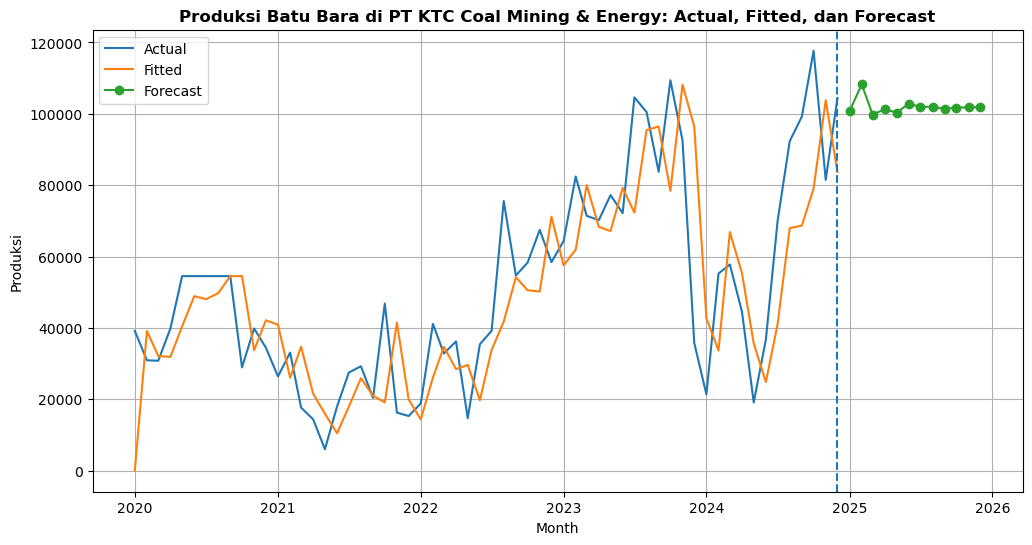

In [55]:
plt.figure(figsize=(12,6))

# Plot actual
plt.plot(df["Month"], df["Actual"], label="Actual")

# Plot fitted
plt.plot(
    df["Month"].iloc[fitted_boxcox.index],
    fitted_original,
    label="Fitted"
)

plt.plot(
    forecast_df["Month"],
    forecast_df["Forecast"],
    label="Forecast", 
    marker="o"
)

plt.axvline(df["Month"].iloc[-1], linestyle="--")
plt.title("Produksi Batu Bara di PT KTC Coal Mining & Energy: Actual, Fitted, dan Forecast", fontsize=12, weight='bold')
plt.xlabel("Month")
plt.ylabel("Produksi")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


### Evaluasi Model dengan MAPE dan RMSE

In [56]:
y_true = df['Actual'].values
y_pred = fitted_original

mape = mean_absolute_percentage_error(y_true, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

MAPE: 37.07%
RMSE: 18524.86
